# Assignment 3_2: Echo State Networks

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float64)

from esn import *
from learning import *

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float64) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float64)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000], y_data[:5000] # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:], y_data[5000:]

train_x, val_x = dev_x[:4000], dev_x[4000:]
train_y, val_y = dev_y[:4000], dev_y[4000:]

In [4]:
dev_x = dev_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
train_x = train_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
val_x = val_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
test_x = test_x.unsqueeze(1).unsqueeze(1)

train_x.shape, val_x.shape, dev_x.shape, test_x.shape # check shapes (L, N, D)

(torch.Size([4000, 1, 1]),
 torch.Size([1000, 1, 1]),
 torch.Size([5000, 1, 1]),
 torch.Size([5000, 1, 1]))

In [5]:
hyperparams = {
    'hidden_size': [512, 1024], 
    'ridge_regression':  [1e-6, 1e-4],
    'omhega_in': [0.6, 0.9],
    'omhega_b': [0.3, 0.6], 
    'rho': [0.8, 0.9, 0.99],
    'washout': [100, 500],
}

model_selection_history = grid_search(hyperparams, train_x, train_y, val_x, val_y, n_iter=5) 

df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('esn_grid_search.csv')

In [7]:
df_results = pd.read_csv('esn_grid_search.csv', index_col=0)
df_results.sort_values(by='val_mse_mean', ascending=True).head(10)

,hidden_size,ridge_regression,omhega_in,omhega_b,rho,washout,train_mse_mean,train_mse_var,val_mse_mean,val_mse_var
config_56,1024,0.000001,0.6,0.6,0.90,100,4.816918e-07,4.710095e-16,9.571961e-07,4.673983e-15
config_57,1024,0.000001,0.6,0.6,0.90,500,4.987553e-07,1.879556e-15,1.033523e-06,1.203392e-14
config_54,1024,0.000001,0.6,0.6,0.80,100,7.708546e-07,4.254250e-14,1.325157e-06,1.718807e-13
config_55,1024,0.000001,0.6,0.6,0.80,500,7.660216e-07,1.552926e-14,1.345230e-06,4.853667e-14
config_58,1024,0.000001,0.6,0.6,0.99,100,7.179157e-07,7.544868e-15,1.538566e-06,8.479265e-14
config_48,1024,0.000001,0.6,0.3,0.80,100,7.620235e-07,3.879033e-15,1.557870e-06,3.541695e-14
config_49,1024,0.000001,0.6,0.3,0.80,500,7.837286e-07,8.087432e-15,1.694182e-06,5.313131e-14
config_59,1024,0.000001,0.6,0.6,0.99,500,7.802789e-07,2.043736e-14,1.984113e-06,2.203683e-13
config_51,1024,0.000001,0.6,0.3,0.90,500,1.017381e-06,1.594270e-14,2.610346e-06,1.269903e-13
config_66,1024,0.000001,0.9,0.6,0.80,100,1.347791e-06,4.199594e-14,2.783463e-06,6.456495e-14


In [10]:
print('Tran MSE:', df_results['train_mse_mean'].min())
print('Val MSE:', df_results['val_mse_mean'].min())

Tran MSE: 4.81691803804529e-07
Val MSE: 9.57196111189914e-07


In [14]:
esn = RegressorESN(1, 1024, ridge_regression=1e-6, omhega_in=0.6, omhega_b=0.6, rho=0.9)
washout = 100
h = esn.fit(dev_x, dev_y, washout)
esn.train()
pred = esn(dev_x, h)

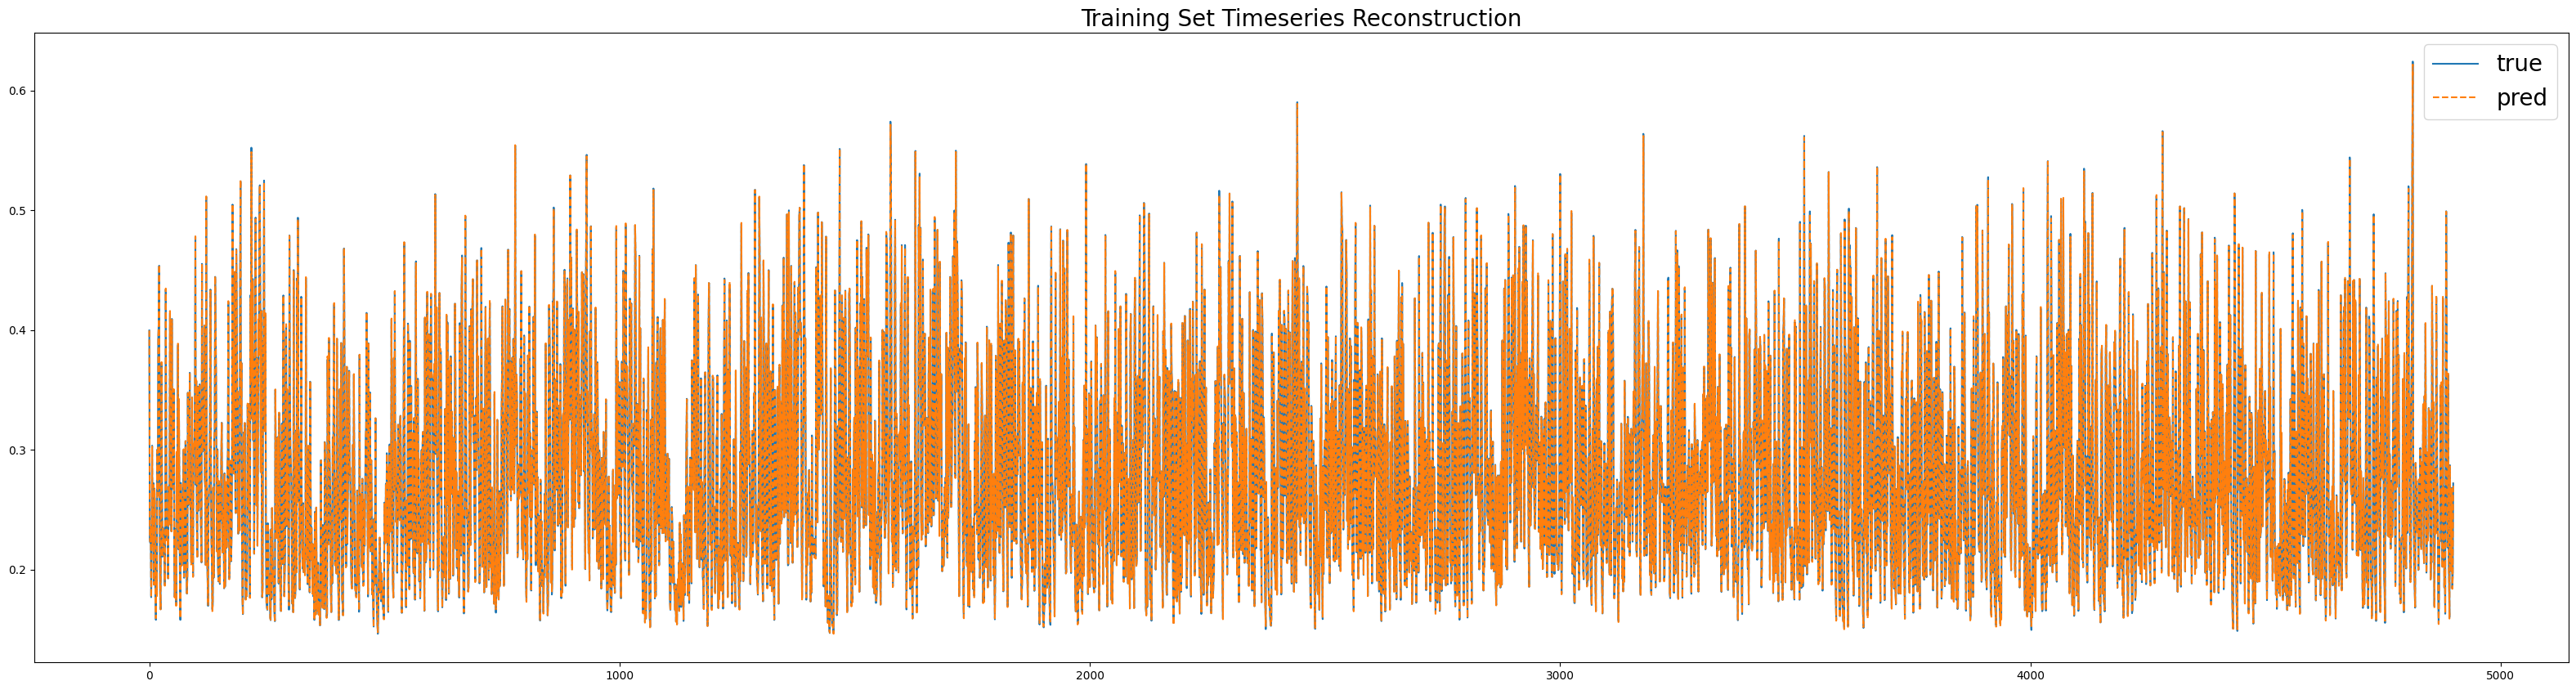

In [15]:
plt.figure(figsize=(40, 10))
plt.title(f'Training Set Timeseries Reconstruction', fontsize=20)
plt.plot(dev_y[washout:], label='true')
plt.plot(pred[washout:], label='pred', linestyle='--')
plt.legend(fontsize=20)

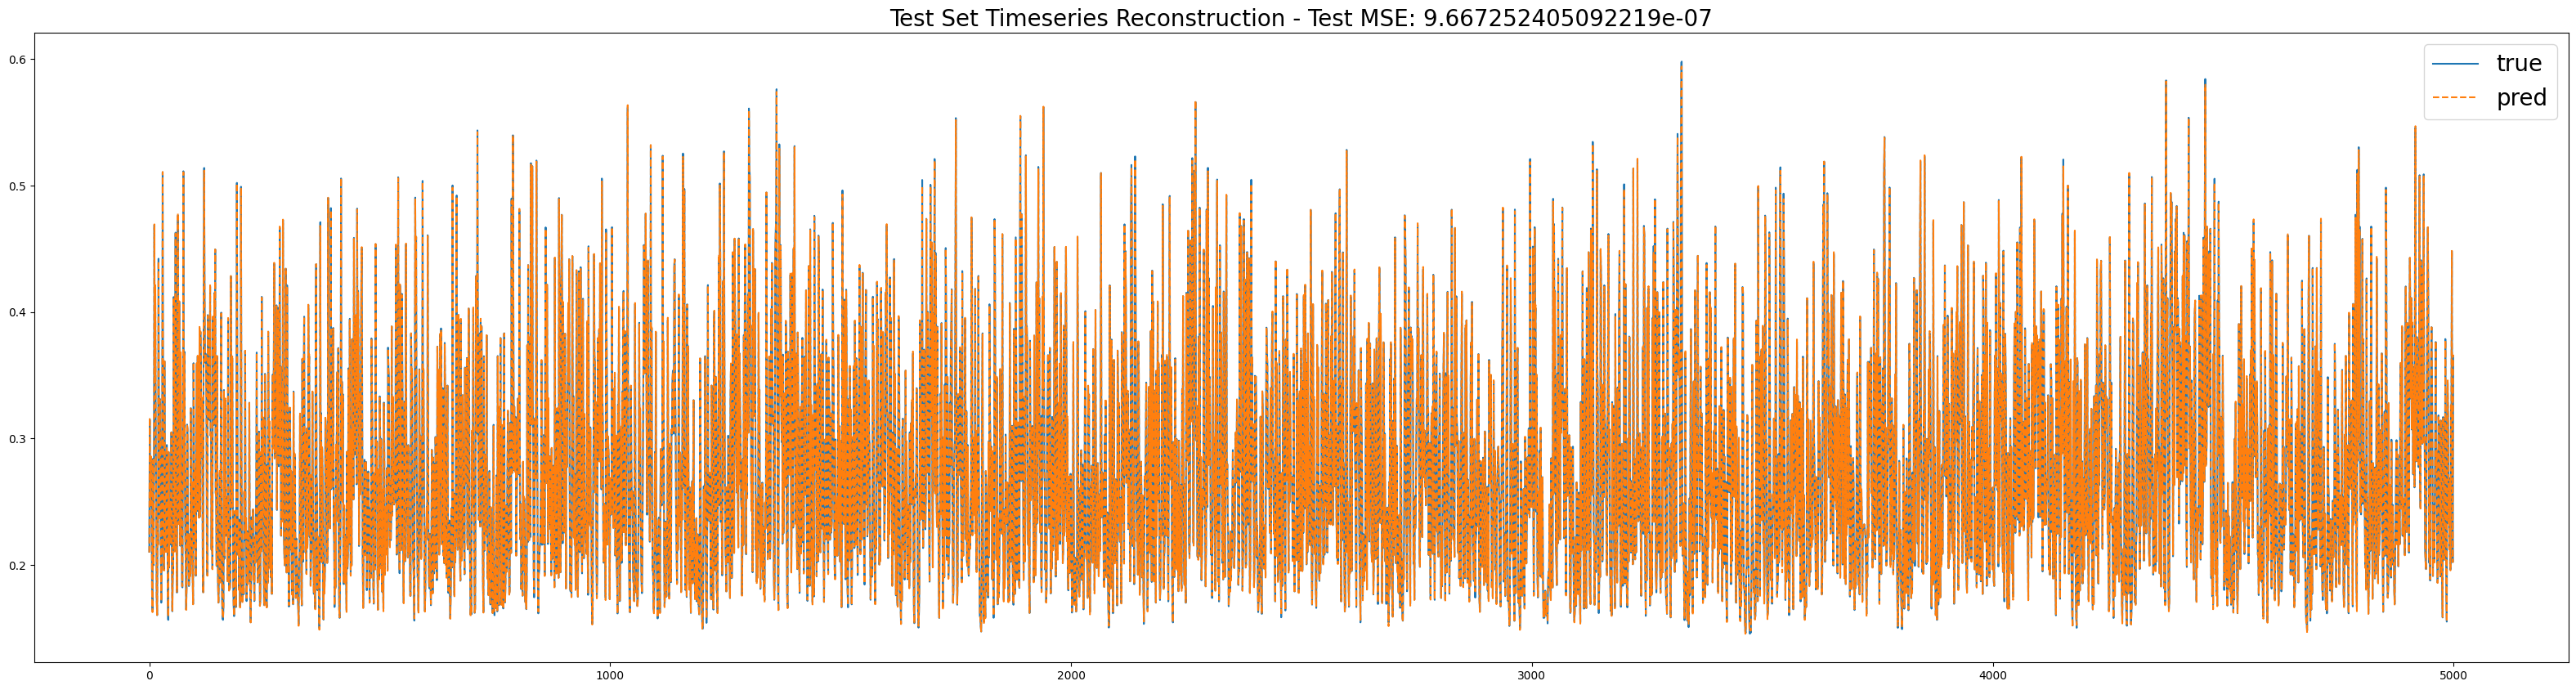

In [16]:
esn.eval()
pred = esn(test_x, h)

l = torch.nn.MSELoss()
test_loss = l(pred, test_y)

plt.figure(figsize=(40, 10))
plt.title(f'Test Set Timeseries Reconstruction - Test MSE: {test_loss.item()}', fontsize=20)
plt.plot(test_y, label='true')
plt.plot(pred, label='pred', linestyle='--')
plt.legend(fontsize=20)